In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import xarray as xr
import random

In [2]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
Y_train = np.load('Y_train.npy')
Y_valid = np.load('Y_valid.npy')

In [7]:
X_train.shape,Y_train.shape, Y_valid.shape

((2700, 64, 96, 12), (2700, 12), (300, 12))

In [4]:
#Write CNN 


def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)
    
    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)
    
    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)
    
    y = keras.layers.Dense(output_shape,activation='relu')(y)   
    
    model = keras.models.Model(inputs=x, outputs=y)
    
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [5]:
#input shape = n_lats,n_lons,12 channels
CNN = create_cnn_model(input_shape=(X_train.shape[1],X_train.shape[2],12), output_shape=12)
# take a look at how the image tensor changes shape as it passes through the CNN:
CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 96, 12)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 96, 8)         872       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 24, 32)        4640  

2022-08-18 18:42:39.521486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = CNN.fit(x = X_train, y = Y_train, epochs=n_epochs, batch_size=50, 
               validation_data=(X_valid,Y_valid))

Epoch 1/20


2022-08-18 18:42:40.026664: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 796262400 exceeds 10% of free system memory.


54/54 [==============================] - 14s 251ms/step - loss: 1.5339 - val_loss: 1.6930
Epoch 2/20
54/54 [==============================] - 13s 243ms/step - loss: 1.5328 - val_loss: 1.6926
Epoch 3/20
54/54 [==============================] - 14s 260ms/step - loss: 1.5215 - val_loss: 1.6116
Epoch 4/20
54/54 [==============================] - 13s 247ms/step - loss: 1.3828 - val_loss: 1.4205
Epoch 5/20
54/54 [==============================] - 13s 242ms/step - loss: 1.2866 - val_loss: 1.3685
Epoch 6/20
54/54 [==============================] - 13s 242ms/step - loss: 1.2315 - val_loss: 1.3090
Epoch 7/20
54/54 [==============================] - 13s 243ms/step - loss: 1.1979 - val_loss: 1.2350
Epoch 8/20
54/54 [==============================] - 14s 256ms/step - loss: 1.1336 - val_loss: 1.2328
Epoch 9/20
54/54 [==============================] - 13s 241ms/step - loss: 1.0998 - val_loss: 1.1684
Epoch 10/20
54/54 [==============================] - 13s 247ms/step - loss: 1.0697 - val_loss: 1.1419


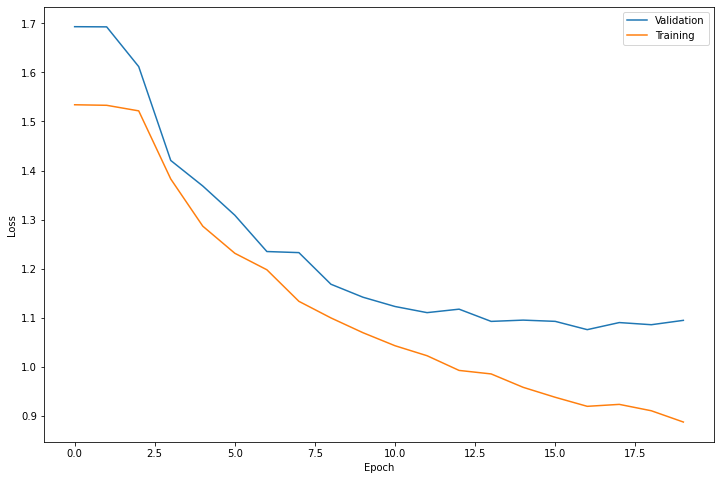

In [8]:
# plot how the accuracy on the training and validation datasets evolved during training
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_loss'],label='Validation')
plt.plot(hist.history['loss'],label='Training')
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

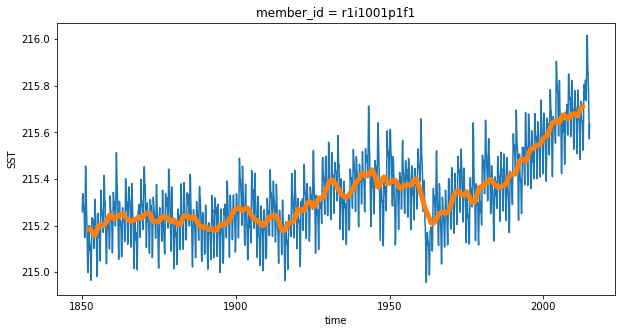

In [9]:
enso1='LENS2/ENSO_SST/ENSO_Project_SST_r1i1001p1f1.nc'
enso1 = xr.open_dataset(enso1)  #xarray can open different format data, netcdf is one of them                              

sst_1 = enso1['SST'].values; df_sst_1 = enso1.to_dataframe()

weights = np.cos(np.deg2rad(enso1.lat)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.
SST_mean = enso1['SST'].weighted(weights).mean(dim=['lat','lon']) # this IS area-weighted mean
SST_mean_runningMean=SST_mean.rolling(time=12*5,center=True).mean() # global mean smoothed over many months

plt.figure(figsize=(10,5))
SST_mean.plot(label="SST" )
SST_mean_runningMean.plot(label="SST rolling mean", linewidth=5 );

enso1_clim=enso1.groupby("time.month").mean('time') # calculate anomalies
enso1_a = enso1.groupby("time.month")-enso1_clim

NINO34 = enso1_a['SST'].sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months



10/10 [==============================] - 0s 41ms/step


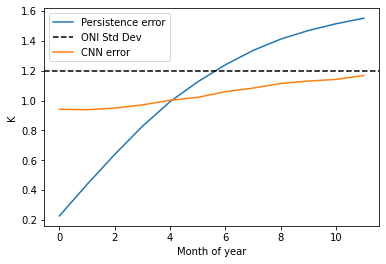

In [13]:
error = np.zeros((300,12))
for i in range(300):
    i0= random.randint(0,len(ONI)-13)
    error[i,:] = (ONI[i0+1:i0+13] - ONI[i0].values*np.ones(12))**2
rms_persistence = (np.mean(error, axis=0))**0.5
plt.plot(rms_persistence,label='Persistence error')
plt.axhline(np.std(ONI), color='k', linestyle='--',label='ONI Std Dev')

#Good if error is within the std dev

#plot model error calculated relative to validation data
#print(np.std(Y))
Y_predictions = CNN.predict(X_valid) 
error = np.sqrt(np.mean((Y_valid - Y_predictions)**2, axis=0)) #Y_valid has shape (300,12)
plt.plot(error,label='CNN error')

plt.ylabel('K')
plt.xlabel('Month of year')
plt.legend()

In [16]:
np.save('Model_Output/Y_predictions_CNN_setup1.npy',Y_predictions)

#plt.savefig('Plots/CNN_1.png')

In [17]:
Y_predictions.shape

(300, 12)

In [18]:
error.shape

(12,)